In [1]:
from Models import Model

# Size plots
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

# SIR Modelling and ABC
*Compartmental Models* are a class of mathematical models used for modelling infectious diseases where each member of the population are assigned to different classes. The SIR Model is a compartmental model where members of the population are either **S**usceptible, **I**nfectious or **R**ecovered.

**Table of Contents**
 * [Motivation](#Motivation)
 * [The SIR Model](#The-SIR-Model)
   * [Specification](#Specification)
   * [Implementation](#Implementation)
 * [Discussion](#Discussion)
 * [SIR and ABC](#SIR-and-ABC)

## Motivation

## The SIR Model
Here I present the classical SIR model which uses ordinary differential equations.

### Specification

Compartmental models are used to model individuals in a population. Each model defines a set of classes which partition the population and defines the mechanics by which individuals can move between populations. Compartmental models are often used to model the spread of something through a population, notably infectious diseases.

I shall present the SIR model for the problem of modelling infectious diseases.

**Classes**

The SIR model is one of the simpliest (but still powerful) compartmental models which uses three classes:
 * **S**usceptible - Individuals who do not currently have the disease, but could catch it if they came into contact with an infectious person.
 * **I**nfectious - Individuals who currently have the disease and are able to spread it.
 * **R**emoved - Individuals who have had the disease in the past and are no longer at risk of infection (either due to death or recovery).

For simple models it is assumed that the total population size is constant and no-one enters or leaves the population.

In this case of a deadly infectious disease we want to move as many people from the susceptible set to the removed set whilst minimising deaths (A subset of the removed set).

**Dynamics**

In the simplest SIR only two transitions are modelled

$$ \text{Susceptible}\to\text{Infectious}\to\text{Removed} $$

In more complicated models other transitions are considered such as $ \text{Susceptible}\to\text{Removed} $ due to a vaccination or $ \text{Removed}\to\text{Susceptible} $ due to immunity wearing off.

Under the simplest SIR model the transition rate per time-period of $ \text{Susceptible}\to\text{Infectious} $ is stated mathematically as
$$ \frac{dS}{dt}=-\beta\frac{SI}{N} $$
where
 * $\beta$ is the average number of contacts for each infected person in a single time-period multiplied by the probability of a contact becoming infected.
 * $N$ is the total population size.
This result is derived similarly to the *Law of Mass Action* which considers random collision between molecules in chemical reactions.
 
The transition rate per time-period of $ \text{Infectious}\to\text{Removed} $ is stated mathematically as
$$ \frac{dI}{dt}=-\gamma I $$
where
 * $\gamma$ is the probability of an individual who is infectious becoming no-longer infectious in a given time-period (either due to death or recovery).
 
With these two transitions we can fully state the SIR model with the following set of ODEs
$$\begin{array}{rcl}
    \frac{dS}{dt}&=&-\beta\frac{IS}{N}\\
    \frac{dI}{dt}&=&\beta\frac{IS}{N}-\gamma I\\
    \frac{dR}{dt}&=&\gamma I
\end{array}$$

Due to the model not allowing for individuals to leave or enter the population, the following results hold
$$\begin{array}{rcl}
    \frac{dS}{dt}+\frac{dI}{dt}+\frac{dR}{dt}&=&0\\
    S(t)+I(t)+R(t)&=&N
\end{array}$$

### Implementation
First I implement a deterministic version of the SIR model described [above](#Specification). This is deterministic as the parameters $\beta,\gamma$ are taken to be deterministic rather 

In [2]:
class SIRModel(Model):

    def __init__(self,params:(int,float,float),n_obs:int):
        """
        DESCRIPTION
        Classical SIR model

        params ((int,int,float,float)) - (population_size,initial_infectied_population_size,beta,gamma)
        n_obs (int) - number of time-periods to run model for
        """

        if (params[0]<params[1]): raise ValueError("Number of initially infected individuals cannot be greater than the population size.")

        # all models have the following
        self.n_params=4
        self.population_size=params[0]
        self.initially_infected=params[1]
        self.beta=params[2]
        self.gamma=params[3]
        self.params=params # parameter values
        
        self.param_labels=["Susceptible","Infectious","Removed"]

        self.n_obs=n_obs # number of observations made by `observe`
        self.dim_obs=3 # dimension of each observation

        self.noise=0 # variance of additive gaussian noise (default=0)

    def update_params(self,new_params:[float]):
        """
        DESCRIPTION
        update the parameters of the model. the observations for `observe` need to be recalculated

        PARAMETERS
        new_paramas ([float]) - new parameter values
        """
        if (len(new_params)!=self.n_params): raise ValueError("Incorrect number of parameters passed. len(params)!=n_params.")

        self.population_size=new_params[0]
        self.initially_infected=new_params[1]
        self.beta=new_params[2]
        self.gamma=new_params[3]

    def observe(self,noise=True) -> [[float]]:
        """
        DESCRIPTION
        generate a sequence of `n_obs` observations from the model, each of dimension `dim_obs`.
        The same sequence is returned each time this function is called.
        sequence is ordered by `x_obs` so is best for `x_obs` to provide a useful ordering.

        PARAMETERS
        None

        RETURNS
        [[float]] - sequence of observations
        """
        return self.__calc()

    def __calc(self) -> [(int,int,int)]:
        """
        DESCRIPTION
        calculate the time-series of observations from the specified SIR model (using ODEs)
        
        RETURNS
        [(int,int,int)] - time-series with each data-point being (S,I,R)
        """
        observations=[(self.population_size-self.initially_infected,self.initially_infected,0)] # [(S,I,R)]

        for t in range(self.n_obs-1):
            last_obs=observations[-1]

            new_infections=int(self.beta*((last_obs[0]*last_obs[1])/self.population_size))
            new_removed   =int(self.gamma*last_obs[1])

            d_S=-new_infections
            d_I=new_infections-new_removed
            d_R=new_removed

            new_obs=(last_obs[0]+d_S,last_obs[1]+d_I,last_obs[2]+d_R)
            observations.append(new_obs)

        return observations
    
    def copy(self,new_params:[float]) -> "Model":
        """
        DESCRIPTION
        create a copy of the model with new parameter values

        PARAMETERS
        new_params ([float]) - new parameter values

        RETURNS
        Model - New copy, with stated parameter values
        """
        if (type(new_params)!=list): raise TypeError("`new_params` shoud be a list (not {})".format(type(new_params)))
        if (len(new_params)!=self.n_params): raise TypeError("`new_params` shoud of length `n_params` ({})".format(self.n_params))

        new_model=SIRModel(new_params,self.n_obs)
        return new_model

    def __str__(self) -> str:
        printing_str="Population Size={:,}\n".format(self.population_size)
        printing_str+="Initially Infected={:,}\n".format(self.initially_infected)
        printing_str+="Beta={:.3f}\n".format(self.beta)
        printing_str+="Gamma={:.3f}".format(self.gamma)

        return printing_str

For demonstration, below I use my `SIRModel` class to define an SIR model for a population of size 100,000 with 100 initially infected people where each infected person infects one susceptible person per day and each day half the infectious people become removed (i.e. average infection lasts 2 days). I run the model over 30 days.

Population Size=100,000
Initially Infected=100
Beta=1.000
Gamma=0.500


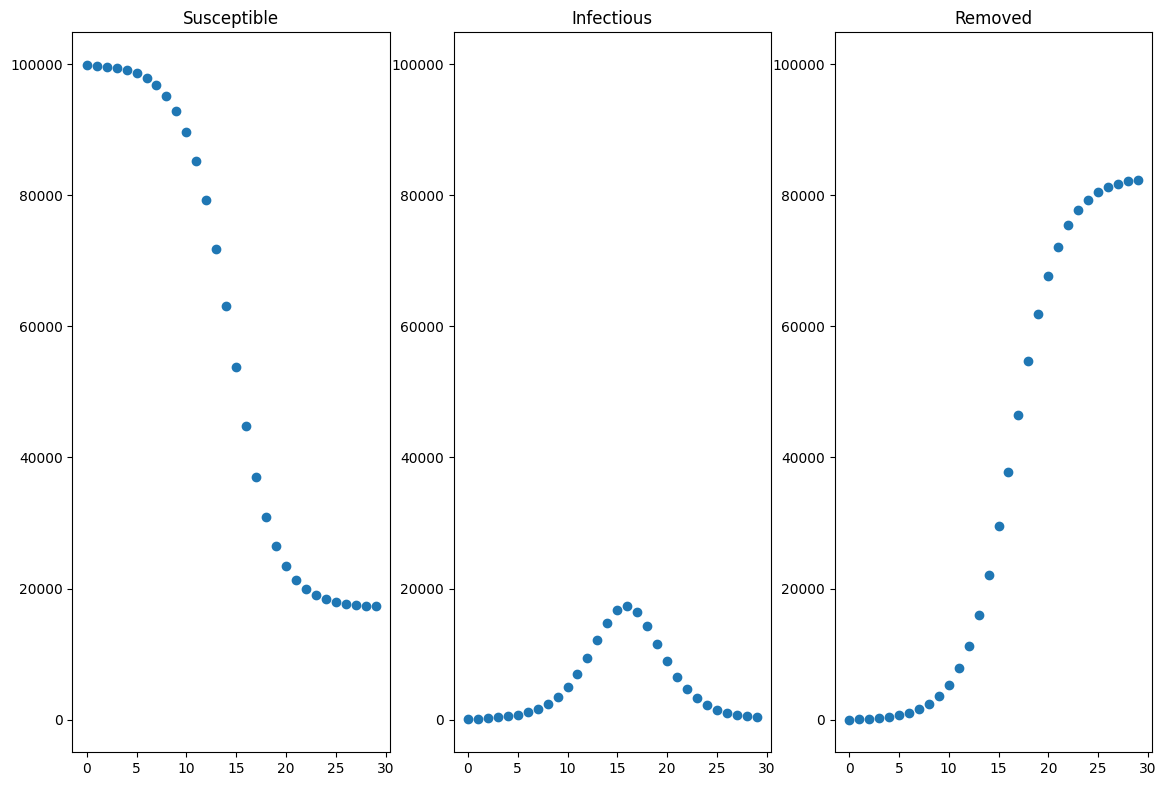

In [3]:
sir_model=SIRModel(params=[100000,100,1,.5],n_obs=30)
print(sir_model)
sir_model.plot_obs(constant_scale=True)

These plots above show that under these conditions
 * The size of the infectious population never exceeds 20,000.
 * The pandemic is almost complete after the 30 days.
 * ~80% of the population ends up being removed. Meaning ~80% of the population become infected in this 30 day period.

## Discussion

Limitations
 * TODO

Extensions
 * Stochastic SIR model
 * Non-constant population size
 * $\beta,\gamma$ vary over time (ie seasonally).

## SIR and ABC